<a href="https://colab.research.google.com/github/marcus-vsantos/PUCRIO/blob/main/Sprint%202/MVP_Sprint_2_PUC_RIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Sprint 2 - Machine Learning e Analytics

---

## Parte A - Machine learning
---

### Definição do problema

O primeiro problema que será abordado ao longo deste trabalho se trata da performance de estudantes universitários. O principal objetivo é o estabelecimento do relacionamento entre a performance de estudantes universitários e de atributos dos estudantes julgados importantes para a performance através de um modelo de regressão.

Os dados são de 10.000 estudantes, onde cada linha representa um estudante e são apresentadas os atributos e a variável de interesse, que é um índice numérico de performance que varia de 10 a 100. O índice de performance é uma espécie de nota global de aproveitamento e, segundo o autor, foi arredondado para o número inteiro mais próximo.

Também cabe ressaltar que, ainda de acordo com o autor, os dados são sintéticos e não revelam um real comportamento observado. Trata-se apenas de uma ilustração da realidade para aplicação de métodos de *machine learning*. Por fim, este dataset foi extraído do site *Kaggle* (disponível em: https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression).

A seguir, a carga dos dados será feita:

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

In [ ]:
url = 'https://raw.githubusercontent.com/marcus-vsantos/PUCRIO/main/Sprint%202/Student_Performance.csv'

raw_students = pd.read_csv(url)

display(raw_students.head(n = 5))

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


Como mostrado a seguir, de fato os dados são de 10.000 estudantes e são dispostos 6 atributos, sendo um o atributo target, que é o índice de performance.

In [ ]:
print(raw_students.shape)

(10000, 6)


Os seis atributos do dataset são apresentados brevemente abaixo:
    
- **Hours Studied:** O número total de horas de estudo de cada estudante
- **Previous Scores:** O score do estudante em provas anteriores.
- **Extracurricular Activities:** Indica se o estudante participou de atividades extracurriculares ou não (Yes/No).
- **Sleep Hours:** A média diária das horas de sono do estudante.
- **Sample Question Papers Practiced:** O número de exames praticados na preparação do estudante.
- **Performance Index:** O número inteiro do indíce de performance de cada estudante, variando de 10 a 100.
    
Como premissas para o problema, tenho que o número de horas estudadas, o score anterior e o número de questões praticadas seriam as mais importantes para a predição da performance do estudante, pois estes estão relacionados com o empenho e a boa preparação do estudante.

Pelo método *info*, percebe-se que não há valores nulos em nenhuma coluna do dataset

In [ ]:
print(raw_students.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB
None


### Preparação dos dados

Inicialmente, as ferramentas auxiliares pertinentes para esta etapa serão carregadas.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

Também, ressalto que, conforme apresentado na seção de "Definição do problema", não há valores faltantes no conjunto de dados, não necessitando o preenchimento destes.

#### Transformação da variável qualitativa

A primeira etapa de preparação dos dados será a criação de uma variável de atividades extracurriculares quantitativa, pois no dataset esse atributo está como qualitativo. Essa é a única variável qualitativa do dataset.

Essa variável é binária, indicando se houve ou não partipação em atividades extracurriculares, conforme apresentado a seguir.

In [ ]:
print(raw_students["Extracurricular Activities"].value_counts())

No     5052
Yes    4948
Name: Extracurricular Activities, dtype: int64


Farei uma transformação dummy que codifica o "Yes" como 1 e o "No" como 0. Para facilitar a compreensão, essa nova coluna ocupará a mesma posição da coluna original.

In [ ]:
students = pd.get_dummies(raw_students, columns = ["Extracurricular Activities"],  drop_first = True)
students = students[['Hours Studied', 'Previous Scores', 'Extracurricular Activities_Yes','Sleep Hours',
       'Sample Question Papers Practiced', 'Performance Index']]

display(students.head(n = 5))

,Hours Studied,Previous Scores,Extracurricular Activities_Yes,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0
3,5,52,1,5,2,36.0
4,7,75,0,8,5,66.0


#### Dados de treino e teste e validação cruzada

Será conduzida a etapa de separação entre os dados de treino e de teste, como indicado abaixo. Os dados de treino serão 70% do dataset, enquanto os de teste serão 30% da base, correspondendo a 7000 e 3000 instâncias, respectivamente.

Também, será utilizada a validação cruzada para avaliação do modelo sob diferentes cenários, avaliando a performance geral. Para a validação cruzada, serão utilizadas 10 partições.

In [ ]:
test_size = 0.30
seed = 100
np.random.seed(seed)

array = students.values
X_students = array[:,0:5]
y_students = array[:,5]
X_students_train, X_students_test, y_students_train, y_students_test = train_test_split(
    X_students, y_students, test_size = test_size, random_state = seed)

num_particoes = 10
kfold = KFold(n_splits = num_particoes, shuffle = True, random_state = seed)

print('Treino:', X_students_train.shape, '\nTeste:', X_students_test.shape)

Treino: (7000, 5) 
Teste: (3000, 5)


Dentre as principais transformações que serão aplicadas, estão a normalização e a padronização. Essas transformações serão utilizadas para evitar, sobretudo, a influência de valores discrepantes.

#### Feature selection

Para a simplificação do problema, é apresentado a seguir a *feature selection* dos dados de treino.

Será utilizado o método *SelectKBest*, onde serão escolhidos os três melhores atributos para a performance do estudante. Como se trata de um problema de regressão, o método *SelectKBest* utilizará como função de score a *f_regression*.

In [ ]:
np.random.seed(seed)

k_best = 3

select_reg =  SelectKBest(k = k_best, score_func = f_regression)
fit_students = select_reg.fit(X_students_train, y_students_train)
features_students = fit_students.transform(X_students_train)

np.set_printoptions(precision = 3)
print("\nScores dos Atributos:", fit_students.scores_)
print("\nAtributos Selecionados:", select_reg.get_feature_names_out(input_features = students.columns[0:5]))


Scores dos Atributos: [1.152e+03 3.612e+04 7.768e+00 1.221e+01 4.879e+00]

Atributos Selecionados: ['Hours Studied' 'Previous Scores' 'Sleep Hours']


Pelo método KBest, conclui-se que as principais variáveis para a performance do estudante são as horas de estudo, o score anterior e o número de horas. É importante ressaltar que apenas o número de exames praticados não se mostrou relevante dentre as três características em que havia a intuição.

### Modelagem e treinamento

As funções apropriadas serão carregadas para a posterior utilização nessa etapa.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

#### Algortimos utilizados

Como se trata de um problema de regressão, serão considerados os seguintes modelos:

- Regressão linear
- Regressão linear Ridge
- Regressão linear Lasso
- Árvore de Regressão
- KNN
- SVM

Para cada modelo, será utilizado os argumentos *defaults*, isto é, não haverá ajuste inicial de hiperparâmetros. Futuramente, serão analisados os melhores hiperparâmetros. Também, será discutida a utilização de modelos ensemble.

LR-orig: MSE 4.109 (0.178) - RMSE 2.027
Ridge-orig: MSE 4.109 (0.178) - RMSE 2.027
Lasso-orig: MSE 4.826 (0.277) - RMSE 2.197
KNN-orig: MSE 6.231 (0.361) - RMSE 2.496
Tree-orig: MSE 9.230 (0.500) - RMSE 3.038
SVM-orig: MSE 5.897 (0.328) - RMSE 2.428
LR-padr: MSE 4.109 (0.178) - RMSE 2.027
Ridge-padr: MSE 4.109 (0.178) - RMSE 2.027
Lasso-padr: MSE 7.185 (0.422) - RMSE 2.680
KNN-padr: MSE 9.618 (0.400) - RMSE 3.101
Tree-padr: MSE 9.125 (0.433) - RMSE 3.021
SVM-padr: MSE 5.788 (0.433) - RMSE 2.406
LR-norm: MSE 4.109 (0.178) - RMSE 2.027
Ridge-norm: MSE 4.110 (0.180) - RMSE 2.027
Lasso-norm: MSE 26.535 (1.044) - RMSE 5.151
KNN-norm: MSE 10.297 (0.460) - RMSE 3.209
Tree-norm: MSE 9.144 (0.445) - RMSE 3.024
SVM-norm: MSE 6.458 (0.441) - RMSE 2.541


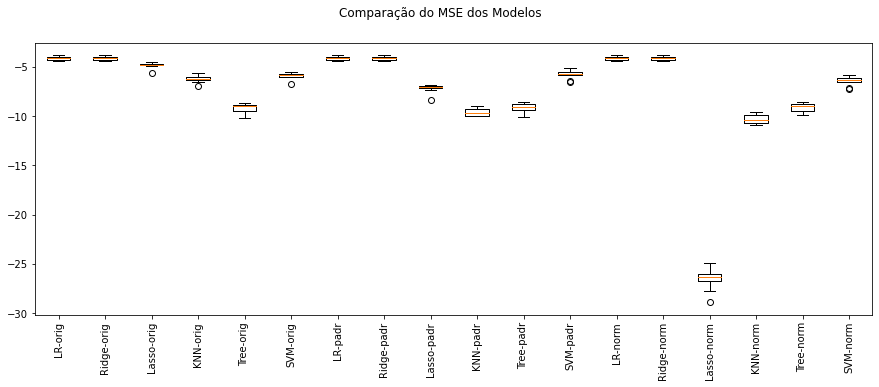

In [ ]:
np.random.seed(seed)

pipelines_students = []
results_students = []
names_students = []
scoring = 'neg_mean_squared_error'

linear = ('LR', LinearRegression())
ridge = ('Ridge', Ridge())
lasso = ('Lasso', Lasso())
knn = ('KNN', KNeighborsRegressor())
tree = ('CART', DecisionTreeRegressor())
svm = ('SVM', SVR())

standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines_students.append(('LR-orig', Pipeline([linear])))
pipelines_students.append(('Ridge-orig', Pipeline([ridge])))
pipelines_students.append(('Lasso-orig', Pipeline([lasso])))
pipelines_students.append(('KNN-orig', Pipeline([knn])))
pipelines_students.append(('Tree-orig', Pipeline([tree])))
pipelines_students.append(('SVM-orig', Pipeline([svm])))

pipelines_students.append(('LR-padr', Pipeline([standard_scaler, linear])))
pipelines_students.append(('Ridge-padr', Pipeline([standard_scaler, ridge])))
pipelines_students.append(('Lasso-padr', Pipeline([standard_scaler, lasso])))
pipelines_students.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines_students.append(('Tree-padr', Pipeline([standard_scaler, tree])))
pipelines_students.append(('SVM-padr', Pipeline([standard_scaler, svm])))

pipelines_students.append(('LR-norm', Pipeline([min_max_scaler, linear])))
pipelines_students.append(('Ridge-norm', Pipeline([min_max_scaler, ridge])))
pipelines_students.append(('Lasso-norm', Pipeline([min_max_scaler, lasso])))
pipelines_students.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines_students.append(('Tree-norm', Pipeline([min_max_scaler, tree])))
pipelines_students.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

for name, model in pipelines_students:
    cv_results = cross_val_score(model, X_students_train, y_students_train, cv = kfold, scoring = scoring)
    results_students.append(cv_results)
    names_students.append(name)
    msg = "%s: MSE %0.3f (%0.3f) - RMSE %0.3f" % (name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean())))
    print(msg)

fig = plt.figure(figsize=(15,5))
fig.suptitle('Comparação do MSE dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results_students)
ax.set_xticklabels(names_students, rotation = 90)
plt.show()

Do resultado apresentado, percebe-se que o modelo de regressão linear foi o de melhor ajuste sob a métrica do MSE, uma vez que obteve os menores valores de erro.

Além disso, a regressão linear tradicional e a com regularização Ridge obtiveram valores próximos, mesmo ao considerar a terceira casa decimal. Ainda, a normalização ou padronização não apresentaram efeitos práticos no ajuste, uma vez que o MSE se manteve o mesmo do que os dados originais mesmo considerando a terceira casa decimal.

Sendo assim, essa primeira análise permite concluir o modelo de regressão linear com os dados originais como o de melhor performance.

### Otimização de hiperparâmetros

Os modelos acima ajustados utilizam os argumentos *default* de cada um dos modelos. Porém, sabe-se que a escolha de hiperparâmetros de modelos de *machine learning* influencia diretamente em seus resultados. Desta forma, torna-se necessário a escolha dos melhores parâmetros para o problema sob questão.

Serão considerados dois modelos: *KNN* e *LinearRegression*. Em um primeiro momento, serão percorridos os parâmetros de número de vizinhos, o cálculo da distância e o algoritmo, conforme evidenciado abaixo.

In [ ]:
###########################################
############# KNN #########################
###########################################

np.random.seed(seed)

pipelines_knn = []

knn = ('KNN', KNeighborsRegressor())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines_knn.append(('knn-orig', Pipeline(steps=[knn])))
pipelines_knn.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines_knn.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
    'KNN__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

for name, model in pipelines_knn:
    grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = scoring, cv = kfold)
    grid.fit(X_students_train, y_students_train)
    print("%s - Melhor: %0.3f usando %s" % (name, grid.best_score_, grid.best_params_))

knn-orig - Melhor: -5.552 usando {'KNN__algorithm': 'brute', 'KNN__metric': 'euclidean', 'KNN__n_neighbors': 15}
knn-padr - Melhor: -8.599 usando {'KNN__algorithm': 'brute', 'KNN__metric': 'euclidean', 'KNN__n_neighbors': 17}
knn-norm - Melhor: -9.645 usando {'KNN__algorithm': 'brute', 'KNN__metric': 'euclidean', 'KNN__n_neighbors': 21}


Sob esta ótica, o método KNN com score "brute", distância euclideana e com 15 vizinhos foi o de melhor performance considerando a lista de parâmetros. Porém, ressalta-se que este ajuste não gerou melhor performance do que a etapa anterior sob a métrica do MSE.

Agora, serão testados os melhores parâmetros para o modelo de regressão linear. Neste caso, será testado apenas se o intercepto do modelo de regressão é necessário ou não no ajuste.

In [ ]:
#########################################
########### Regressão linear ############
#########################################

np.random.seed(seed)

pipelines_lr = []

# Definindo os componentes do pipeline
lr = ('LR', LinearRegression())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines_lr.append(('lr-orig', Pipeline(steps=[lr])))
pipelines_lr.append(('lr-padr', Pipeline(steps=[standard_scaler, lr])))
pipelines_lr.append(('lr-norm', Pipeline(steps=[min_max_scaler, lr])))

param_grid = {
    'LR__fit_intercept': [True, False]
}

for name, model in pipelines_lr:
    grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = scoring, cv = kfold)
    grid.fit(X_students_train, y_students_train)
    print("%s - Melhor: %0.3f usando %s" % (name, grid.best_score_, grid.best_params_))

lr-orig - Melhor: -4.109 usando {'LR__fit_intercept': True}
lr-padr - Melhor: -4.109 usando {'LR__fit_intercept': True}
lr-norm - Melhor: -4.109 usando {'LR__fit_intercept': True}


Sob esta ótica, o método *LinearRegression* resultou em estimativas parecidas com os modelos da etapa de *Algoritmos utilizados*, com MSE próximo dos demais. Além disso, a presença do intercepto é significativa para o modelo, pois em todos os sub-modelos, o de melhor performance apresentava o intercepto.

### Modelos ensemble

Entre as técnicas mais avançadas de modelos, serão utilizados alguns comitês de modelos. Esse cenário será avaliado para ver se as predições podem ser melhoradas.

Bag-orig: nan (nan)
Vot-orig: -4.469 (0.200)
GB-orig: -4.374 (0.199)
Ada-orig: -7.457 (0.578)
RF-orig: -5.328 (0.252)
ET-orig: -6.090 (0.292)
Bag-padr: nan (nan)
Vot-padr: -4.768 (0.260)
GB-padr: -4.374 (0.199)
Ada-padr: -7.434 (0.610)
RF-padr: -5.317 (0.252)
ET-padr: -6.101 (0.279)
Bag-norm: nan (nan)
Vot-norm: -4.897 (0.261)
GB-norm: -4.374 (0.199)
Ada-norm: -7.475 (0.567)
RF-norm: -5.313 (0.240)
ET-norm: -6.086 (0.278)


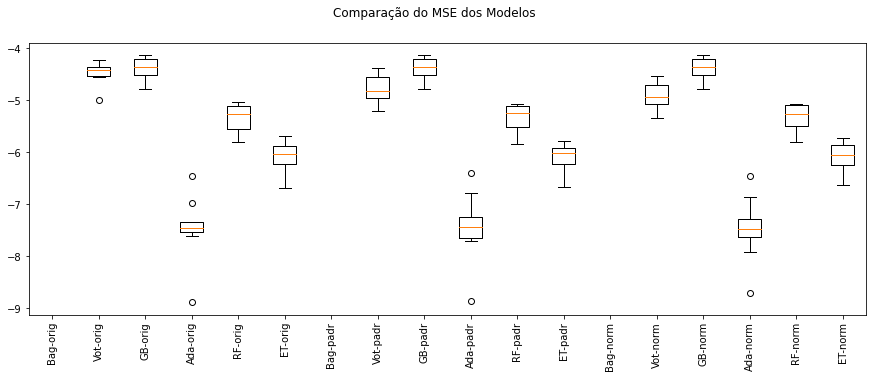

In [ ]:
np.random.seed(seed)

pipeline_ensemble = []
results_ensemble = []
names_ensemble = []

standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

max_f = 4
num_trees = 200

bases = []
bases.append(('tree', KNeighborsRegressor()))
bases.append(('lr', LinearRegression()))
bases.append(('svr', SVR()))
bases.append(('gb_base', GradientBoostingRegressor(n_estimators = num_trees)))

bagging = ('Bag', BaggingRegressor(base_estimator = bases, n_estimators = num_trees))
voting = ('Voting', VotingRegressor(bases))
gradient_boosting = ('GB', GradientBoostingRegressor(n_estimators = num_trees))
adaboost = ('Ada', AdaBoostRegressor(n_estimators = num_trees))
random_forest = ('RF', RandomForestRegressor(n_estimators = num_trees, max_features = max_f))
extra_trees = ('ET', ExtraTreesRegressor(n_estimators = num_trees, max_features = max_f))

standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipeline_ensemble.append(('Bag-orig', Pipeline([bagging])))
pipeline_ensemble.append(('Vot-orig', Pipeline([voting])))
pipeline_ensemble.append(('GB-orig', Pipeline([gradient_boosting])))
pipeline_ensemble.append(('Ada-orig', Pipeline([adaboost])))
pipeline_ensemble.append(('RF-orig', Pipeline([random_forest])))
pipeline_ensemble.append(('ET-orig', Pipeline([extra_trees])))

pipeline_ensemble.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipeline_ensemble.append(('Vot-padr', Pipeline([standard_scaler, voting])))
pipeline_ensemble.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipeline_ensemble.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipeline_ensemble.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipeline_ensemble.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))

pipeline_ensemble.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipeline_ensemble.append(('Vot-norm', Pipeline([min_max_scaler, voting])))
pipeline_ensemble.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipeline_ensemble.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipeline_ensemble.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipeline_ensemble.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))

for name, model in pipeline_ensemble:
    cv_results = cross_val_score(model, X_students_train, y_students_train, cv = kfold, scoring = scoring)
    results_ensemble.append(cv_results)
    names_ensemble.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,5))
fig.suptitle('Comparação do MSE dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results_ensemble)
ax.set_xticklabels(names_ensemble, rotation = 90)
plt.show()

Portanto, percebe-se que os modelos de *GradientBoosting* apresentaram os melhores resultados nos três cenários (originais, padronizados e normalizados). Além disso, não houve diferença significativa no ajuste ao padronizar ou normalizar as variáveis, uma vez que a estimativa do MSE foi igual nesses três modelos considerando até a terceira casa decimal.

Caso fosse necessário que um desses modelos *ensemble* fosse utilizado, é possível selecionar o modelo com os dados originais, facilitando a interpretabilidade do modelo final.

### Avaliação dos resultados

Conforme apresentado nas etapas anteriores, os modelos de melhor performance foram *LinearRegression*, *LinearRegression Ridge* e *LinearRegression Lasso*. Também, a transformação das variáveis não se revelou significativa, seja a normalização ou a padronização.

Dada a semelhança entre os ajustes dos três modelos acima, será verificada a performance destes na base de teste, conforme apresentado a seguir, com as suas respectivas métricas de desempenho, sendo apresentados o MSE e o coeficiente de determinação R2.

In [ ]:
np.random.seed(seed)

modelo_lr = LinearRegression()
modelo_lr.fit(X_students_train, y_students_train)
pred1 = modelo_lr.predict(X_students_test)

modelo_ridge = Ridge()
modelo_ridge.fit(X_students_train, y_students_train)
pred2 = modelo_ridge.predict(X_students_test)

modelo_lasso = Lasso()
modelo_lasso.fit(X_students_train, y_students_train)
pred3 = modelo_lasso.predict(X_students_test)

print("LinearRegression: MSE: %.4f - R2: %.4f"
      % (mean_squared_error(y_students_test, pred1), r2_score(y_students_test, pred1)))

print("Ridge: MSE: %.4f - R2: %.4f"
      % (mean_squared_error(y_students_test, pred2), r2_score(y_students_test, pred2)))

print("Lasso: MSE: %.4f - R2: %.4f"
      % (mean_squared_error(y_students_test, pred3), r2_score(y_students_test, pred3)))

LinearRegression: MSE: 4.2772 - R2: 0.9885
Ridge: MSE: 4.2772 - R2: 0.9885
Lasso: MSE: 5.0598 - R2: 0.9864


Conforme apresentado acima, percebe-se que os modelo de *LinearRegression* e *LinearRegression Ridge* apresentaram os melhores desempenhos, tanto sob a ótica do MSE quanto da ótica do coeficiente de determinação R2. Além disso, ambos os modelos apresentaram métricas muito próximas, mesmo quando considerada a quarta casa decimal. O R2 esteve próximo de 1, indicando boa performance do modelo.

O modelo considerado como final será o *LinearRegression*. Para este modelo, a figura a seguir apresenta o diagrama de dispersão da variável predita e observada na base de treino.

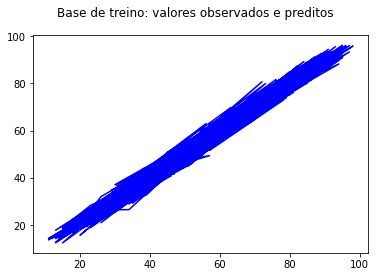

In [ ]:
plt.suptitle('Base de treino: valores observados e preditos')
plt.plot(y_students_test, pred1, color='b')
plt.show()

O diagrama de dispersão acima mostra que os valores observados e preditos foram próximos, pela sua familiaridade com a reta identidade **y = x**.

As métricas acima mencionadas corroboram o bom ajuste do modelo *LinearRegression*, de modo que não foi identificado overfitting e houve boa aderência na base de teste.

### Conclusão

Com base no exposto, é possível perceber que o modelo de *LinearRegression* foi o de melhor performance, mesmo sob o ponto de vista de diferentes métricas apropriadas para a avaliação da performance de um problema supervisionado de regressão.

Para este problema, ressalta-se que não foi necessária a transformação de variáveis, pois os modelos apresentaram resultados similares com e sem transformação.

Por brevidade e por não se tratar de uma exaustiva análise, a otimização de hiperparâmetros considerou apenas dois modelos de regressão, a saber: *KNN* e *LinearRegression*. Sendo assim, tornou-se uma limitação dos resultados apresentados. Porém, o modelo final apresentou uma excelente performance, com quase 99% da variabilidade da variável target sendo explicada pelo modelo de regressão linear.

Sendo assim, conclui-se que a variavél target de Índice de performance do aluno é explicada por uma combinação linear das covariáveis *Hours Studied*, *Previous Scores*, *Extracurricular Activities*, *Sleep Hours* e *Sample Questions paper practiced*, e que portanto estas são importantes para a predição de performances.

---
## Parte B - Deep Learning
---

### Definição do problema

Na segunda etapa deste presente trabalho, será conduzida a análise de sentimentos (*Sentiment Analysis*) através do processamento de linguagem natural.

Os dados são oriundos de um dataset do *Kaggle* (https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis), que contém manchetes e comentários do ramo financeiro a respeito de assuntos diversos, como a expectativas de PIB e previsões de mercado. Além disso, o dataset é a combinação de informações oriundas de duas fontes principais: *FIQA* e *FinancialPhraseBank*.

Para cada comentário, é identificado um sentimento atrelado a este, sendo classificado como positivo, negativo ou neutro. O autor do dataset não entrou em detalhes a respeito do méotodo utilizado para classificação do comentário. Também, o autor não especificou restrições e vieses do dataset.

A seguir, serão feitas a importação de bibliotecas e a carga dos dados. Além disso, são exibidas as primeiras linhas do dataset.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
from collections import defaultdict

import spacy
import nltk
import gensim

import logging
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
url_financ = 'https://raw.githubusercontent.com/marcus-vsantos/PUCRIO/main/Sprint%202/Financial_Sentiment_Analysis.csv'
financial_raw = pd.read_csv(url_financ)

display(financial_raw.head(n = 5))

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


#### Descrição do dataset

O dataset contém apenas dois atributos de interesse, sendo descritas a seguir:

- **Sentence**: Comentário realizado
- **Sentiment**: Sentimento mais notório observado

Também, são dados de 5842 e não há dados nulos nas duas colunas do dataset, conforme evidenciado abaixo.

In [ ]:
print('Dimensão do dataset:', financial_raw.shape, '\n')
print('Total de valores nulos por coluna:\n', financial_raw.isnull().sum())

Dimensão do dataset: (5842, 2) 

Total de valores nulos por coluna:
 Sentence     0
Sentiment    0
dtype: int64


Por fim, será apresentada na imagem a seguir a contagem dos sentimentos atrelados aos comentários.

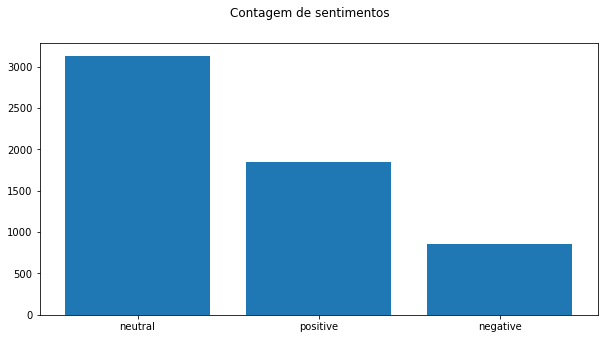

In [ ]:
contagem = financial_raw['Sentiment'].value_counts()

fig = plt.figure(figsize = (10,5))
fig.suptitle('Contagem de sentimentos')
ax = fig.add_subplot(111)
plt.bar(contagem.index, contagem.values)
plt.show()

Também, a tabela a seguir apresenta a frequência relativa dos sentimentos.

In [ ]:
print('Frequência relativa (em %)\n\n',
    financial_raw['Sentiment'].value_counts(normalize = True).mul(100).round(1))

Frequência relativa (em %)

 neutral     53.6
positive    31.7
negative    14.7
Name: Sentiment, dtype: float64


Conclui-se que a maioria dos sentimentos são neutros, presente em 53,6% dos comentários. Além disso, há mais que o dobro de observações positivas do que negativas.

### Preparação dos dados

O primeiro passo a ser realizado para a preparação dos dados será a separação dos atributos de comentários e de sentimento em variáveis específicas. É apresentada essa etapa abaixo.

In [ ]:
array_financ = financial_raw.values
X = array_financ[:, 0]
y = array_financ[:, 1]

Agora, serão desabilitadas a identificação de associações e entidades para obtenção de melhor performance computacional. Também, será realizada a lemmatização e a remoção de stopwords e números para limpeza do texto. Como auxílio, será utilizada a função *cleaning*, disponível no módulo de Processamento de Linguagem Natural.

In [ ]:
raw_text = "\n".join(X.tolist())

#spacy.cli.download("en_core_web_sm")
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

def cleaning(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    if len(txt) > 2:
        return ' '.join(txt)

new_str = re.sub(r'[^\w\s]', '', raw_text).lower()
new_str = re.sub(r'[^A-Za-z\W]+', '', new_str)
doc = nlp(new_str)
txt = cleaning(doc)
txt = txt.split('\n')

print(
    'Texto 1: ', txt[0], '\n',
    'Texto 2: ', txt[1], '\n',
    'Texto 3: ', txt[2])

Texto 1:  geosolution technology leverage benefon s gps solution provide location base search technology   community platform   location relevant multimedia content new powerful commercial model  
 Texto 2:   esi low     bk real possibility  
 Texto 3:   quarter    componenta s net sale double eurm eurm period year early   move zero pretax profit pretax loss eurm 


Agora, os textos limpos e o sentimento associado serão visualizados em forma de data frame para a posterior análise. Também, serão feitas outras duas operações.

Primeiramente, serão removidos os espaços em branco excessivos, e também serão removidos os espaços em branco do início e final do texto. Em segundo lugar, será criado uma classificação numérica para a variável de sentimento, onde esta assume 1 em caso de sentimento negativo, 0 em caso de sentimento neutro e 2 em caso de sentimento positivo.  

In [ ]:
data_dict = {'texto': txt, 'sentimento': y}
df_clean = pd.DataFrame(data_dict)
df_clean = df_clean.dropna().drop_duplicates()

df_clean = df_clean.assign(
    texto = lambda dataframe: dataframe['texto'].map(lambda texto: re.sub(' +', ' ', texto).strip())
)

le = LabelEncoder()
df_clean['sentimento'] = le.fit_transform(df_clean['sentimento'])

print('Formato:', df_clean.shape)
display(df_clean.head(n = 5))

Formato: (5786, 2)


,texto,sentimento
0,geosolution technology leverage benefon s gps ...,2
1,esi low bk real possibility,0
2,quarter componenta s net sale double eurm eurm...,2
3,accord finnishrussian chamber commerce major c...,1
4,swedish buyout firm sell remain percent stake ...,1


### Separação em base de treino e base de teste

A separação da base de treino e de teste será conduzida de forma estratificada, uma vez que foi possível concluir na análise descritiva que a proporção de comentários de cada sentimento é diferente.

Serão utilizados 30% dos dados para teste e 70% para treino. Além disso, será conduzida a validação cruzada estratificada de 10 vezes. A validação cruzada estratificada é necessária pelo mesmo motivo apresentado acima.

In [ ]:
test_size2 = 0.30
seed2 = 43
np.random.seed(seed2)

array2 = df_clean.values
X_feeling = array2[:, 0]
y_feeling = array2[:, 1]
y_feeling = y_feeling.astype('int')

X_feeling_train, X_feeling_test, y_feeling_train, y_feeling_test = train_test_split(
    X_feeling, y_feeling, test_size = test_size2, random_state = seed2, stratify = y_feeling)

num_particoes = 10
kfold = StratifiedKFold(n_splits = num_particoes, shuffle = True, random_state = seed2)

print('Treino:', X_feeling_train.shape, '\nTeste:', X_feeling_test.shape)

Treino: (4050,) 
Teste: (1736,)


Conclui-se que são 4628 comentários para treino e 1158 para teste, respeitando os 70% e 30% de treino e teste definidos na etapa anterior, respectivamente.

### Transformações de dados

Como as operações realizadas até o momento produziram textos, torna-se necessária uma conversão de texto para número para que os modelos de *machine learning* e/ou *deep learning* possam ser utilizados.

Para isso, será feita a operação de conversão para *Bag of words (BOW)*, com o auxílio da função *CountVectorizer*.

In [ ]:
operation = CountVectorizer()

X_feeling_train_bow = operation.fit_transform(X_feeling_train).toarray()
X_feeling_test_bow = operation.transform(X_feeling_test).toarray()

print('Dimensão de treino:', X_feeling_train_bow.shape, '\n')
print(X_feeling_train_bow)

Dimensão de treino: (4050, 7398) 

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Pelo resultado apresentado e por se tratar de uma análise de comentários, é possível supor que a bag of words formada seja esparsa, pois 7967 atributos que compõe cada comentário realizado.

### Feature selection

Pelo significado prático da BOW, não será utilizado *feature selection* neste problema.



### Modelagem e treinamento

#### Algoritmos utilizados

Por questões de performance computacional, serão utilizados apenas dois algoritmos de classificação para comparação: O *KNN* e o *DecisionTreeClassifier*. Além disso, não será utilizada a normalização e padronização.

As etapas e os pipelines encontram-se abaixo.

KNN-orig: 0.584 (0.010)
CART-orig: 0.627 (0.029)


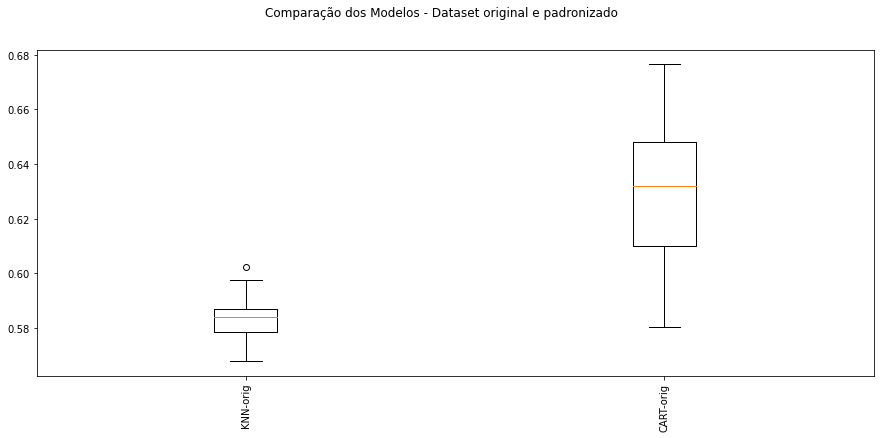

In [ ]:
np.random.seed(seed2)

pipelines_feeling = []
results_feeling = []
names_feeling = []
scoring = 'accuracy'

knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())

pipelines_feeling.append(('KNN-orig', Pipeline([knn])))
pipelines_feeling.append(('CART-orig', Pipeline([cart])))

for name, model in pipelines_feeling:
    cv_results2 = cross_val_score(model, X_feeling_train_bow, y_feeling_train, cv = kfold, scoring = scoring)
    results_feeling.append(cv_results2)
    names_feeling.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results2.mean(), cv_results2.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,6))
fig.suptitle('Comparação dos Modelos - Dataset original')
ax = fig.add_subplot(111)
plt.boxplot(results_feeling)
ax.set_xticklabels(names_feeling, rotation=90)
plt.show()

Percebe-se que o modelo de *DecisionTreeClassifier* performou melhor que o KNN, obtendo uma acurácia média de 62,7%. Sendo assim, esse modelo é preferível em relação ao KNN considerando esta métrica.

### Otimização de hiperparâmetros

Como não foi feita restrição sob os parâmetros, torna-se necessário verificar se a escolhe destes é ótima, que será analisada a seguir.

Para isso, serão variados os parâmetros de número de vizinhos e métrica de distância do KNN. Também, a profundidade máxima do DecisionTreeClassifier, que será fixada em 2.

In [ ]:
################################
########### KNN ################
################################

np.random.seed(seed2)

pipelines_feeling2 = []
results_feeling2 = []
names_feeling2 = []
scoring = 'accuracy'

knn = ('KNN', KNeighborsClassifier())

pipelines_feeling2.append(('KNN-orig', Pipeline([knn])))

param_grid3 = {
    'KNN__n_neighbors': [7, 9, 11, 13, 15],
    'KNN__metric': ["euclidean", "manhattan"],
}

for name, model in pipelines_feeling2:
    grid = GridSearchCV(estimator = model, param_grid = param_grid3, scoring = scoring, cv = kfold)
    grid.fit(X_feeling_train_bow, y_feeling_train)
    print("%s - Melhor: %0.3f usando %s" % (name, grid.best_score_, grid.best_params_))

###################################
############ CART #################
###################################

np.random.seed(seed2)

pipelines_feeling2 = []
results_feeling2 = []
names_feeling2 = []
scoring = 'accuracy'

cart = ('CART', DecisionTreeClassifier())

pipelines_feeling2.append(('CART-orig', Pipeline([cart])))

param_grid3 = {
    'CART__max_depth': [None, 2],
}

for name, model in pipelines_feeling2:
    grid = GridSearchCV(estimator = model, param_grid = param_grid3, scoring = scoring, cv = kfold)
    grid.fit(X_feeling_train_bow, y_feeling_train)
    print("%s - Melhor: %0.3f usando %s" % (name, grid.best_score_, grid.best_params_))

KNN-orig - Melhor: 0.585 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 7}
CART-orig - Melhor: 0.627 usando {'CART__max_depth': None}


Conclui-se que o método KNN apresentou melhor performance sob a métrica do Manhattan e 7 vizinhos mais próximos. Porém, o incremento na acurácia do KNN foi de 0.01. Também, o método CART foi melhor sobre a profundidade padrão (*None*), e por isso a acurácia foi a mesma do ajuste da etapa anterior.

#### Modelos ensemble

Também por questão de performance computacional, apenas dois modelos ensemble de classificação serão avaliados: *RandomForest* (RF) e *GradientBoosting* (GB). Também, não será feita a padronização ou normalização, e o número de árvores para o GB e o RF será de apenas 20, também por questão de performance.

GB-orig: 0.620 (0.012)
RF-orig: 0.655 (0.030)


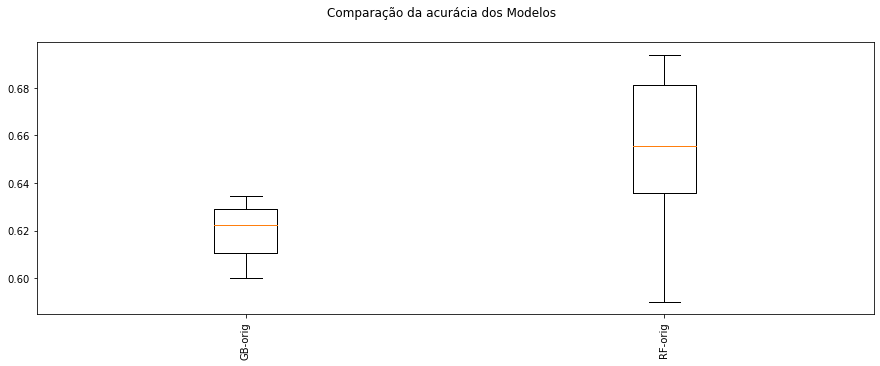

In [ ]:
np.random.seed(seed2)

pipeline_ensemble2 = []
results_ensemble2 = []
names_ensemble2 = []

num_trees = 20

gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators = num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators = num_trees))

pipeline_ensemble2.append(('GB-orig', Pipeline([gradient_boosting])))
pipeline_ensemble2.append(('RF-orig', Pipeline([random_forest])))

for name, model in pipeline_ensemble2:
    cv_results = cross_val_score(model, X_feeling_train_bow, y_feeling_train, cv = kfold, scoring = scoring)
    results_ensemble2.append(cv_results)
    names_ensemble2.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,5))
fig.suptitle('Comparação da acurácia dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results_ensemble2)
ax.set_xticklabels(names_ensemble2, rotation = 90)
plt.show()

Percebe-se que, mesmo com apenas 20 árvores no GB e no RF, eles obtiveram boa estimativa. A acurácia do GB ficou levemente abaixo do CART com os dados originais, que era até então o modelo de melhor acurácia.

#### Avaliação de resultados

Conclui-se das etapas anteriores que o modelo de melhor ajuste geral foi o RF, com acurácia acima dos demais modelos. Porém, será considerado também o segundo melhor modelo ajustado (*DecisionTreeClassifier*), pois obteve acurácia próxima do RF.

Sendo assim, estes serão os modelos avaliados na base de teste.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

## RANDOM FOREST
modelo_rf = RandomForestClassifier(n_estimators = 20)
modelo_rf.fit(X_feeling_train_bow, y_feeling_train)
pred_feeling_rf = modelo_rf.predict(X_feeling_test_bow)

print('Acurácia geral RF: %.3f\n' % (accuracy_score(y_feeling_test, pred_feeling_rf)))
print(classification_report(y_feeling_test, pred_feeling_rf))

## DECISION TREE
modelo_dt = DecisionTreeClassifier()
modelo_dt.fit(X_feeling_train_bow, y_feeling_train)
pred_feeling_dt = modelo_dt.predict(X_feeling_test_bow)

print('Acurácia geral KNN: %.3f\n' % (accuracy_score(y_feeling_test, pred_feeling_dt)))
print(classification_report(y_feeling_test, pred_feeling_dt))

Acurácia geral RF: 0.618

              precision    recall  f1-score   support

           0       0.24      0.20      0.22       257
           1       0.65      0.78      0.71       928
           2       0.73      0.54      0.62       551

    accuracy                           0.62      1736
   macro avg       0.54      0.51      0.52      1736
weighted avg       0.61      0.62      0.61      1736

Acurácia geral KNN: 0.591

              precision    recall  f1-score   support

           0       0.22      0.28      0.24       257
           1       0.67      0.65      0.66       928
           2       0.68      0.64      0.66       551

    accuracy                           0.59      1736
   macro avg       0.52      0.52      0.52      1736
weighted avg       0.61      0.59      0.60      1736



Percebe-se que a acurácia do modelo final na base de teste foi próxima da acurácia na base de treino para ambos os modelos. Além disso, seguimos com a conclusão de que o RF foi o modelo de melhor performance geral, tanto na base de treino como na base de teste. Portanto, será o modelo final a ser escolhido sob a métrica da acurácia.

### Conclusão

A análise de sentimentos é uma área de difícil predição, uma vez que as palavras contêm significados diferentes em contextos diferentes. Porém, foi possível observar como o processamento de linguagem natural é utilizado para esta área do conhecimento.

Após limpeza e transformações de dados, ressalta-se que os textos obtiveram uma boa acurácia geral. Não houve overfitting, pois obteve boa acurácia na base de teste. Além disso, não houve underfitting, pois obteve boa acurácia na base de treino. Porém, tem-se a criticar alguns outros fatores.

Primeiramente, os modelos ficaram limitados computacionalmente por exigir um alto desempenho. Também, percebe-se que o recall do modelo final foi relativamente baixo, sendo de apenas 0.22.

Convém, portanto, a realização de outras análises neste mesmo dataset, considerando possivelmente alguns pontos de limitação que foram levantados.